In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [44]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [45]:
apple = sio.loadmat('matlab.mat')

In [46]:
apple_data = apple['ans']
apple_data = np.squeeze(apple_data)

In [3]:
msft = np.load('msft.npy')

In [47]:
train_data = apple_data[:-10]
test_data = apple_data[-10:]

In [48]:
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1, 1))

In [49]:
train_input = torch.from_numpy(train_data_normalized).type(torch.Tensor).view(-1)

In [50]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        train_seq = train_seq.to(device)
        train_label = train_label.to(device)
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [51]:
train_inout_seq = create_inout_sequences(train_input, 5)

In [52]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [53]:
model = LSTM()
model = model.to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [54]:
model

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [55]:
epochs = 500

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        
    if i % 100 == 0:
        print("Epoch ", i, "MSE: ", single_loss.item())

Epoch  0 MSE:  4.056841135025024e-06
Epoch  100 MSE:  0.002634258009493351
Epoch  200 MSE:  0.002713938243687153
Epoch  300 MSE:  0.002336913486942649
Epoch  400 MSE:  0.0014857639325782657


In [56]:
test_inputs = train_input[-5:].tolist()
print(test_inputs)

[0.7694462537765503, 0.8101417422294617, 1.0, 0.9373547434806824, 0.943602979183197]


In [57]:
model.eval()

for i in range(10):
    seq = torch.FloatTensor(test_inputs[-5:]).to(device)
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))
        test_inputs.append(model(seq).item())

In [104]:
print(test_inputs)
actual_predictions = scaler.inverse_transform(np.array(test_inputs[5:] ).reshape(-1, 1))
test_data_normalized = scaler.fit_transform(test_data.reshape(-1, 1))
print(actual_predictions)
MSE = np.square(np.subtract(test_data_normalized,test_inputs)).mean()
print(MSE)

[0.7694462537765503, 0.8101417422294617, 1.0, 0.9373547434806824, 0.943602979183197, 0.8362186551094055, 0.7939661145210266, 0.9531319737434387, 0.9154329299926758, 1.0768038034439087, 0.9243696331977844, 0.967128574848175, 0.8808355331420898, 0.8563279509544373, 1.0050891637802124]
[[323.06614449]
 [322.63432348]
 [324.26099872]
 [323.87571446]
 [325.52492495]
 [323.96704758]
 [324.404044  ]
 [323.52212903]
 [323.27166152]
 [324.79200126]]
0.5410536306776894


In [59]:
x = np.arange(121, 131, 1)
print(x)

[121 122 123 124 125 126 127 128 129 130]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


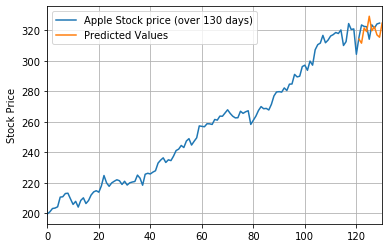

In [60]:
plt.show()
plt.ylabel('Stock Price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(apple_data, label='Apple Stock price (over 130 days)')
plt.plot(x,actual_predictions, label='Predicted Values')
ax = plt.subplot(111)
ax.legend()

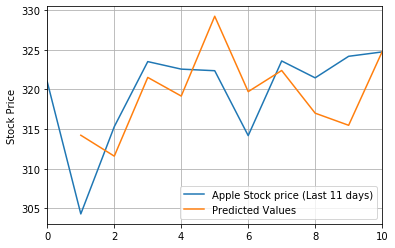

In [103]:
x = np.arange(1, 11, 1)
plt.show()
plt.ylabel('Stock Price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(apple_data[119:130], label='Apple Stock price (Last 11 days)')
plt.plot(x,actual_predictions, label='Predicted Values')
plt.legend()

In [95]:
classification = np.zeros(10)
class_labels = np.zeros(10)
for i in range(10):
    a = np.sign(apple_data[120 + i] - apple_data[120 + i - 1])
    if i == 0:
        b = np.sign(actual_predictions[i] - apple_data[120 + i - 1])
    else:
        b = np.sign(actual_predictions[i] - actual_predictions[i - 1])
        
    class_labels[i] = a
    classification[i] = b
print(class_labels)
print(classification)

[-1.  1.  1. -1. -1. -1.  1. -1.  1.  1.]
[-1. -1.  1. -1.  1. -1.  1. -1. -1.  1.]


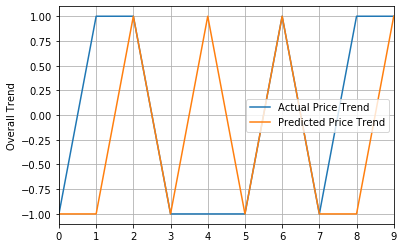

In [102]:
x = np.arange(0, 10, 1)
plt.show()
plt.ylabel('Overall Trend')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(x,class_labels, label='Actual Price Trend')
plt.plot(x,classification, label='Predicted Price Trend')
plt.legend()

In [63]:
print(apple_data[127])

321.470001


In [64]:
print(len(train_data_normalized))

120


In [68]:
print(train_inout_seq)

[(tensor([-1.0000, -0.9776, -0.9433, -0.9385, -0.9253], device='cuda:0'), tensor([-0.8238], device='cuda:0')), (tensor([-0.9776, -0.9433, -0.9385, -0.9253, -0.8238], device='cuda:0'), tensor([-0.8196], device='cuda:0')), (tensor([-0.9433, -0.9385, -0.9253, -0.8238, -0.8196], device='cuda:0'), tensor([-0.7858], device='cuda:0')), (tensor([-0.9385, -0.9253, -0.8238, -0.8196, -0.7858], device='cuda:0'), tensor([-0.7826], device='cuda:0')), (tensor([-0.9253, -0.8238, -0.8196, -0.7858, -0.7826], device='cuda:0'), tensor([-0.8428], device='cuda:0')), (tensor([-0.8238, -0.8196, -0.7858, -0.7826, -0.8428], device='cuda:0'), tensor([-0.9000], device='cuda:0')), (tensor([-0.8196, -0.7858, -0.7826, -0.8428, -0.9000], device='cuda:0'), tensor([-0.8680], device='cuda:0')), (tensor([-0.7858, -0.7826, -0.8428, -0.9000, -0.8680], device='cuda:0'), tensor([-0.9282], device='cuda:0')), (tensor([-0.7826, -0.8428, -0.9000, -0.8680, -0.9282], device='cuda:0'), tensor([-0.8577], device='cuda:0')), (tensor([